# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

Warning message:
“package ‘Rcpp’ was built under R version 4.0.2”
Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.4.6)
than is installed on your system (1.0.7). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”
Warning message:
“replacing previous import ‘xcms::plot’ by ‘graphics::plot’ when loading ‘CAMERA’”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.2”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.0.2”
Warning message:
“package ‘DelayedArray’ was built under R version 4.0.2”
Warning message:
“package ‘matrixStats’ was built under R version 4.0.2”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.2”
Warning message:
“packa

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [2]:
## List mzXML files
mzXMLs <- list.files(path = "PGC_neg", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(12,8,9,10,14,6,7,13,16,15,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17697 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Thu Oct 21 12:26:24 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Thu Oct 21 12:26:25 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] QC_1.mzXML...  [17] QC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0116 F01.S0117 ... F17.S1156 (17697 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [3]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "PCYP", "QC")

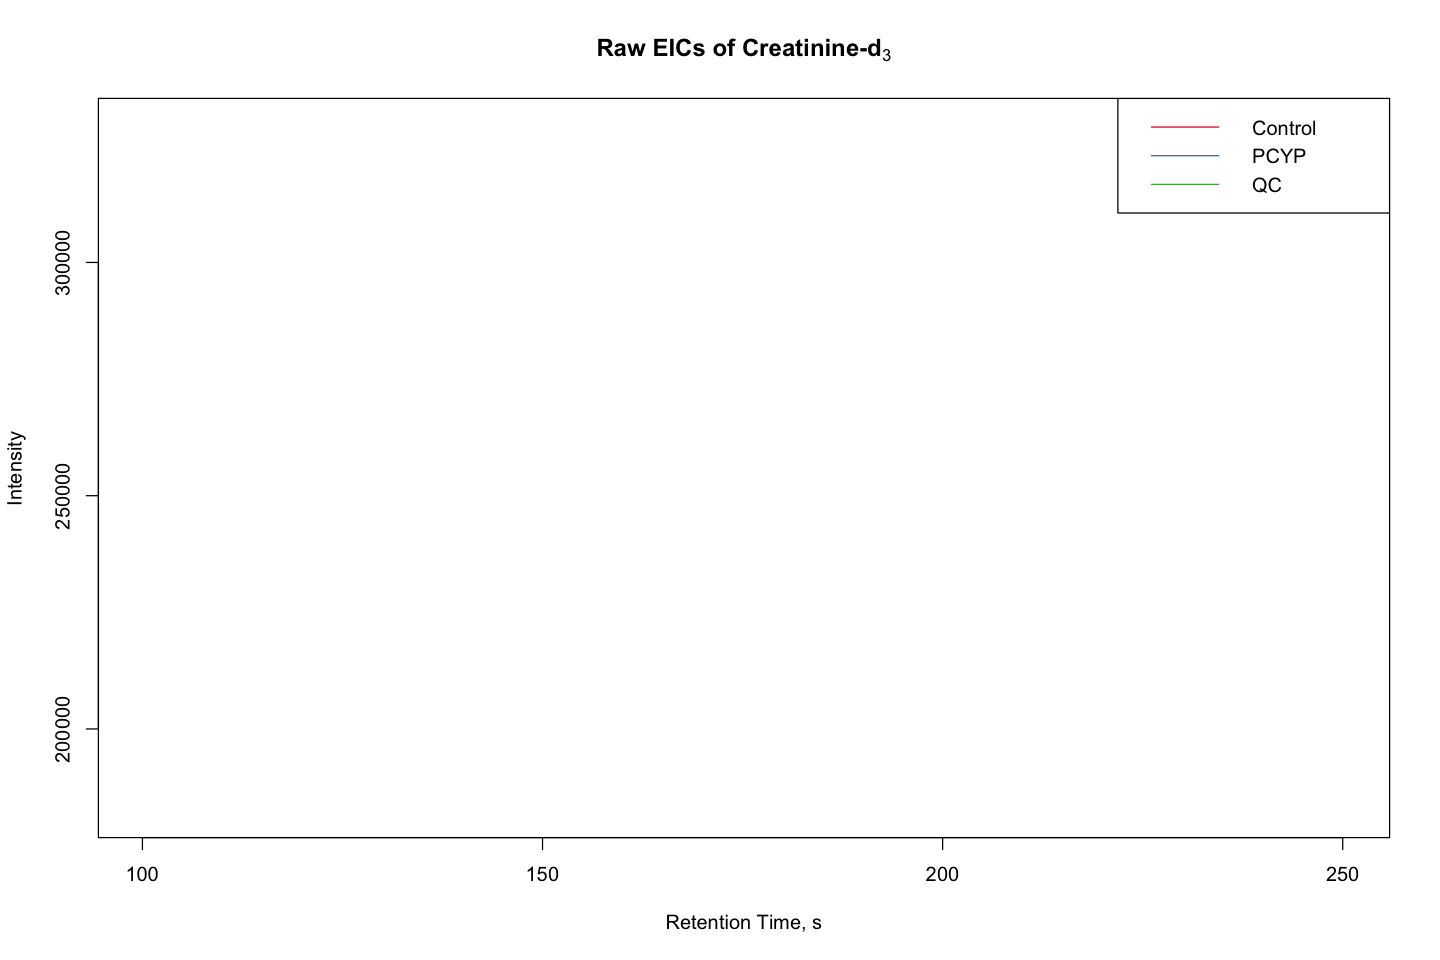

In [4]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(100, 250))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

Warning message in .local(x, ...):
“All chromatograms empty”


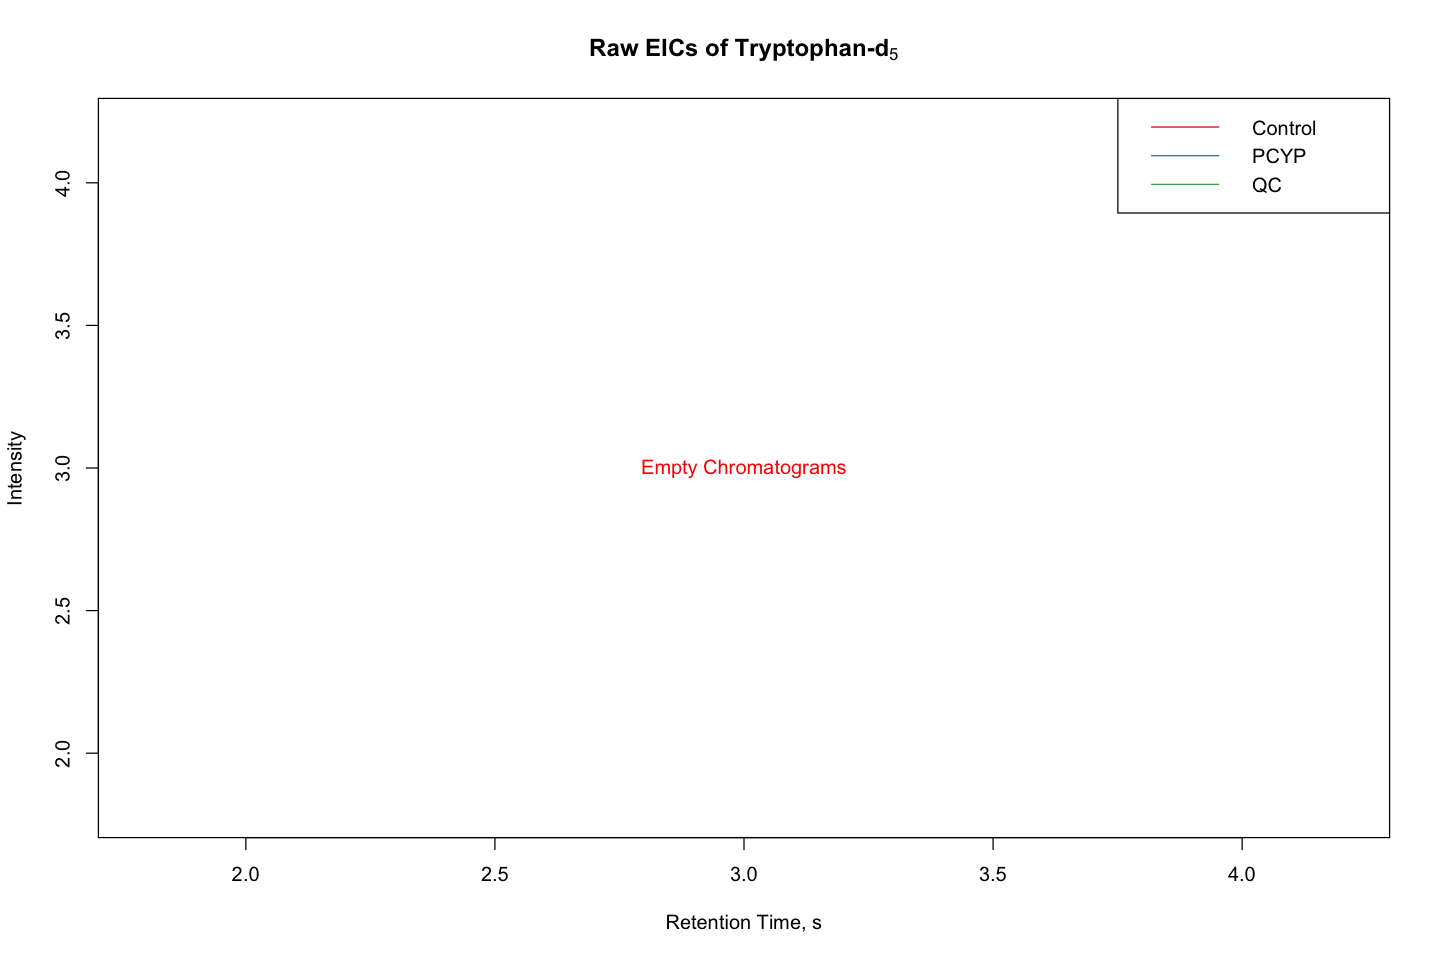

In [5]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1280, 210.1296), rt = c(0, 800))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [6]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

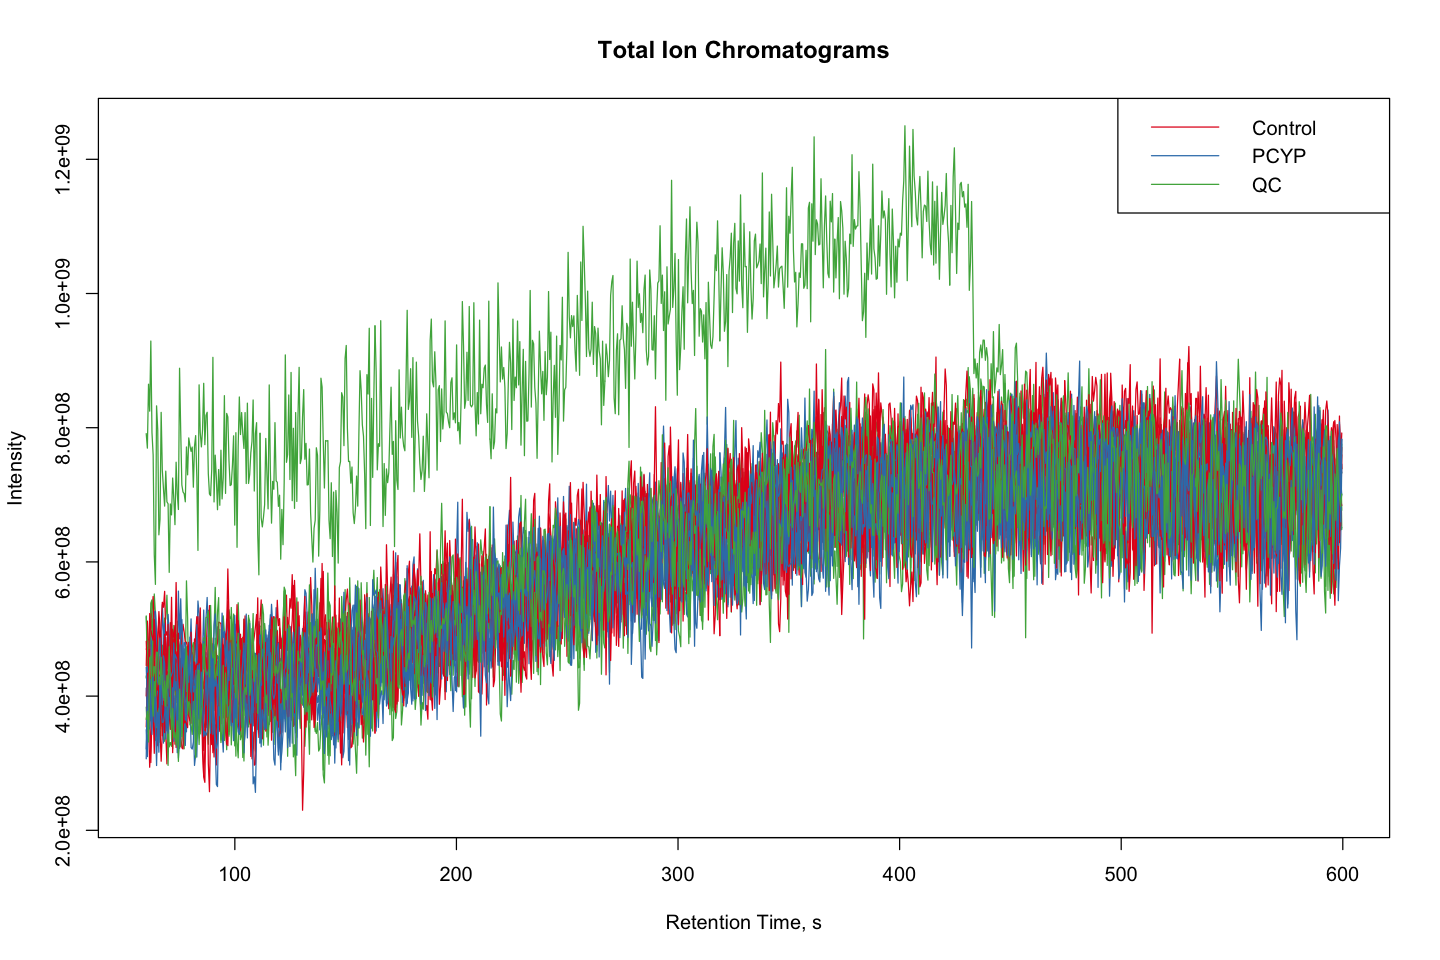

In [7]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

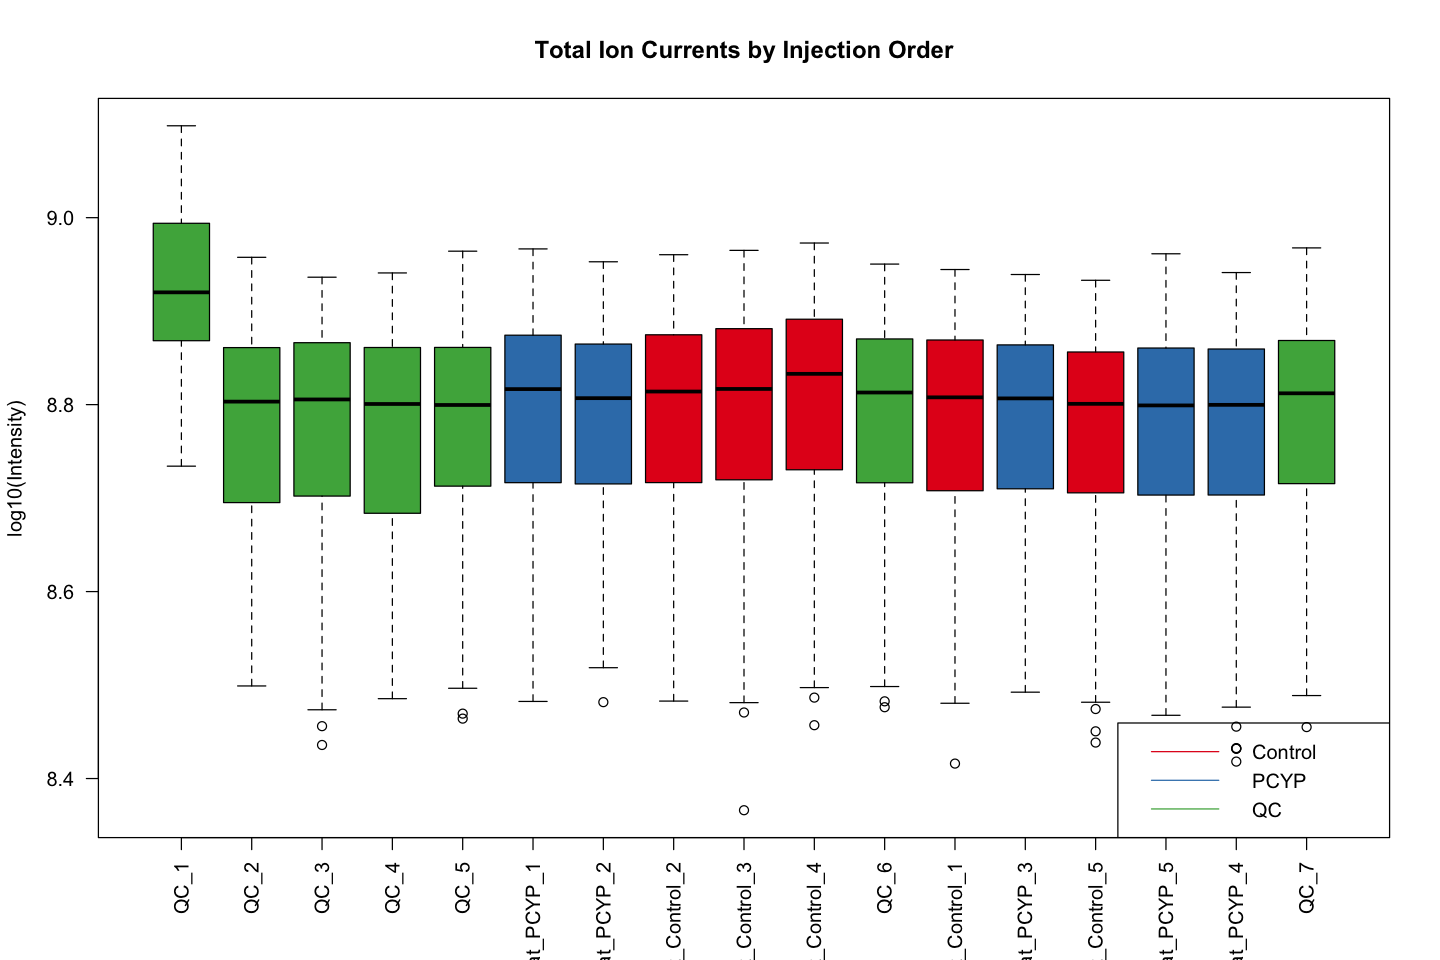

In [8]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [9]:
cwp <- CentWaveParam(peakwidth = c(5.8, 44), ppm = 2.0, snthresh = 4, 
                     mzdiff = 0.1,  prefilter = c(54, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [10]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

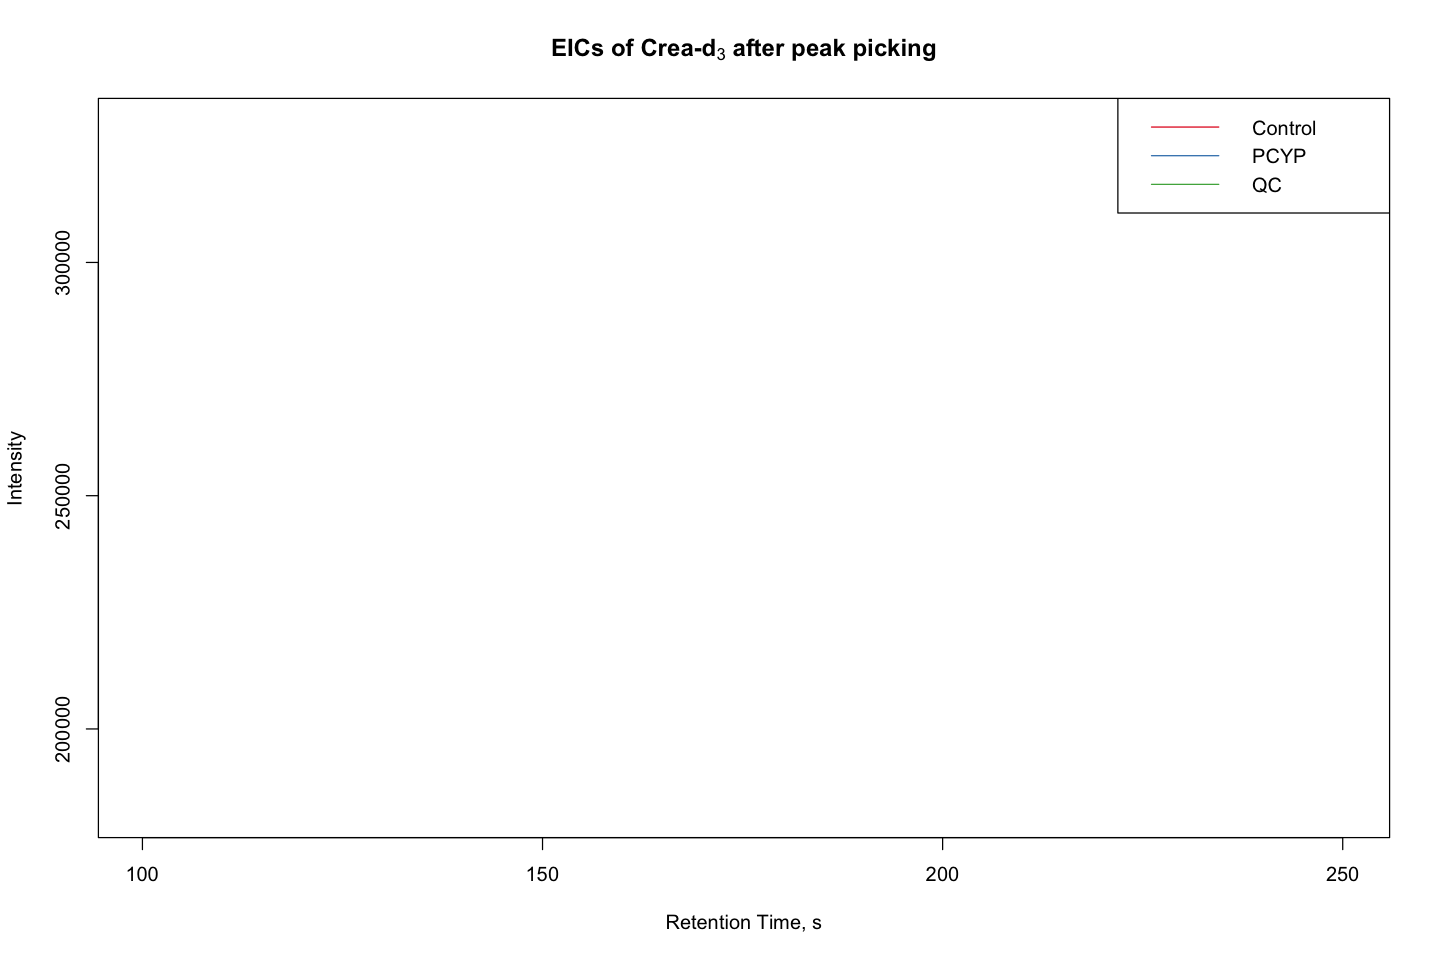

In [11]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
cread3.picked <- chromatogram(set, mz = c(117.0841, 117.0871), rt = c(100, 250)) 

plot(cread3.picked, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.picked)[, "sample"]],
     main = bquote(bold("EICs of Crea-d"[3]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [16]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.1))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

Warning message in do_adjustRtime_peakGroups(chromPeaks(object, msLevel = msLevel), :
“Too few peak groups for 'loess', reverting to linear method”


ERROR: Error in do_adjustRtime_peakGroups(chromPeaks(object, msLevel = msLevel), : Not enough peak groups even for linear smoothing available!


Warning message in plotAdjustedRtime(set, col = group.colours[set$sample_group], :
“No alignment/retention time correction results present.”
Warning message in .local(object, ...):
“Adjusted retention times requested but none present. returning raw retention times instead.”
Warning message in .local(object, ...):
“Adjusted retention times requested but none present. returning raw retention times instead.”


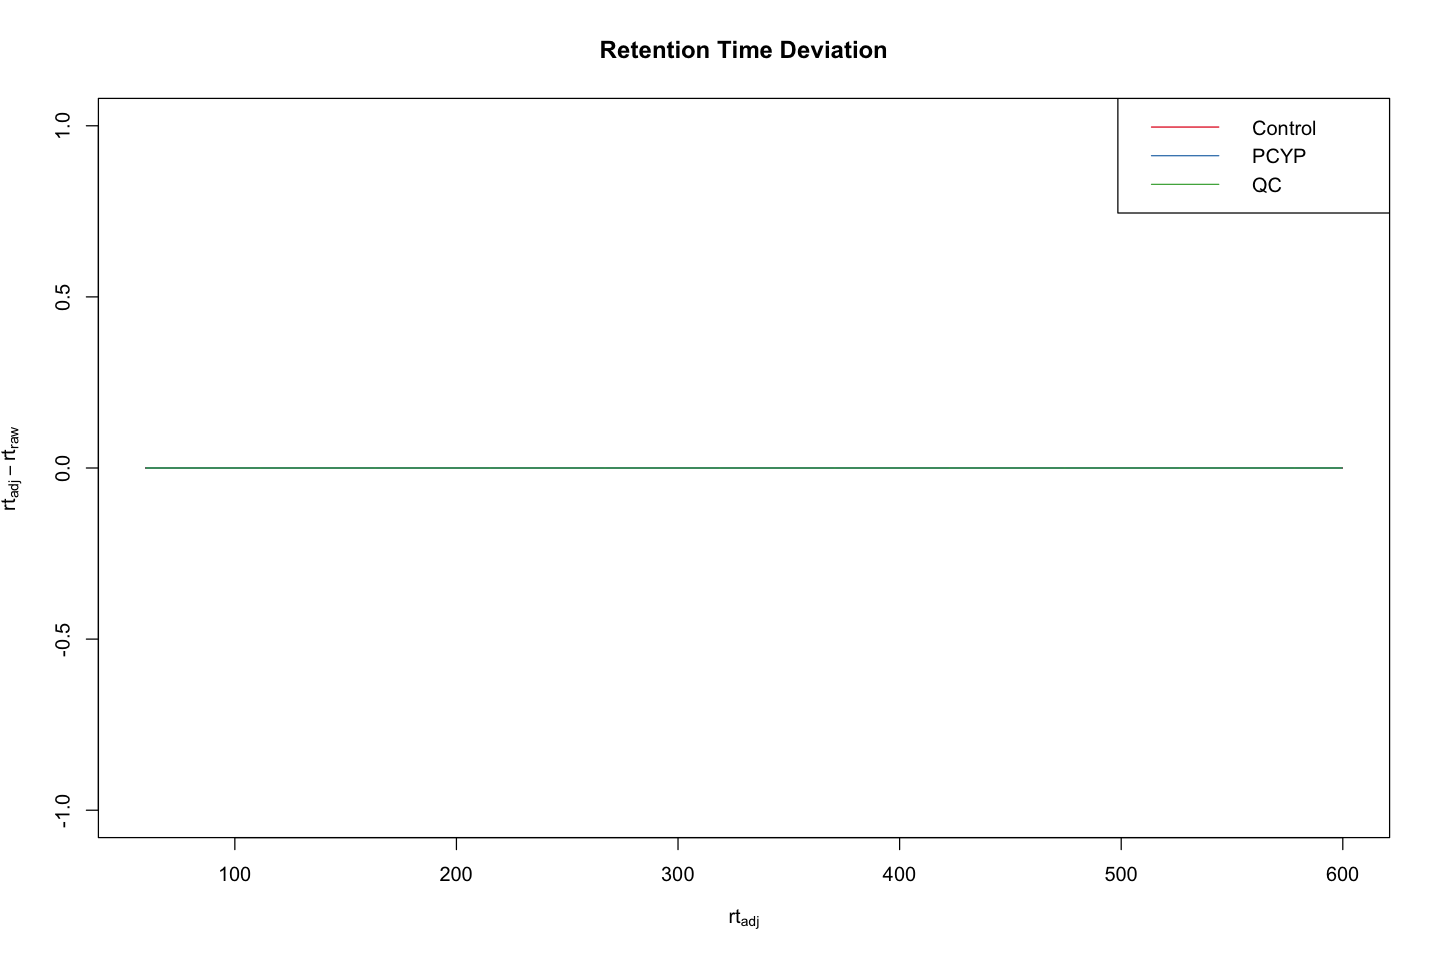

In [17]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [18]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

ERROR: Error in .mz_chromatograms(object, mz = "mz"): Chromatograms in row 1 have different mz


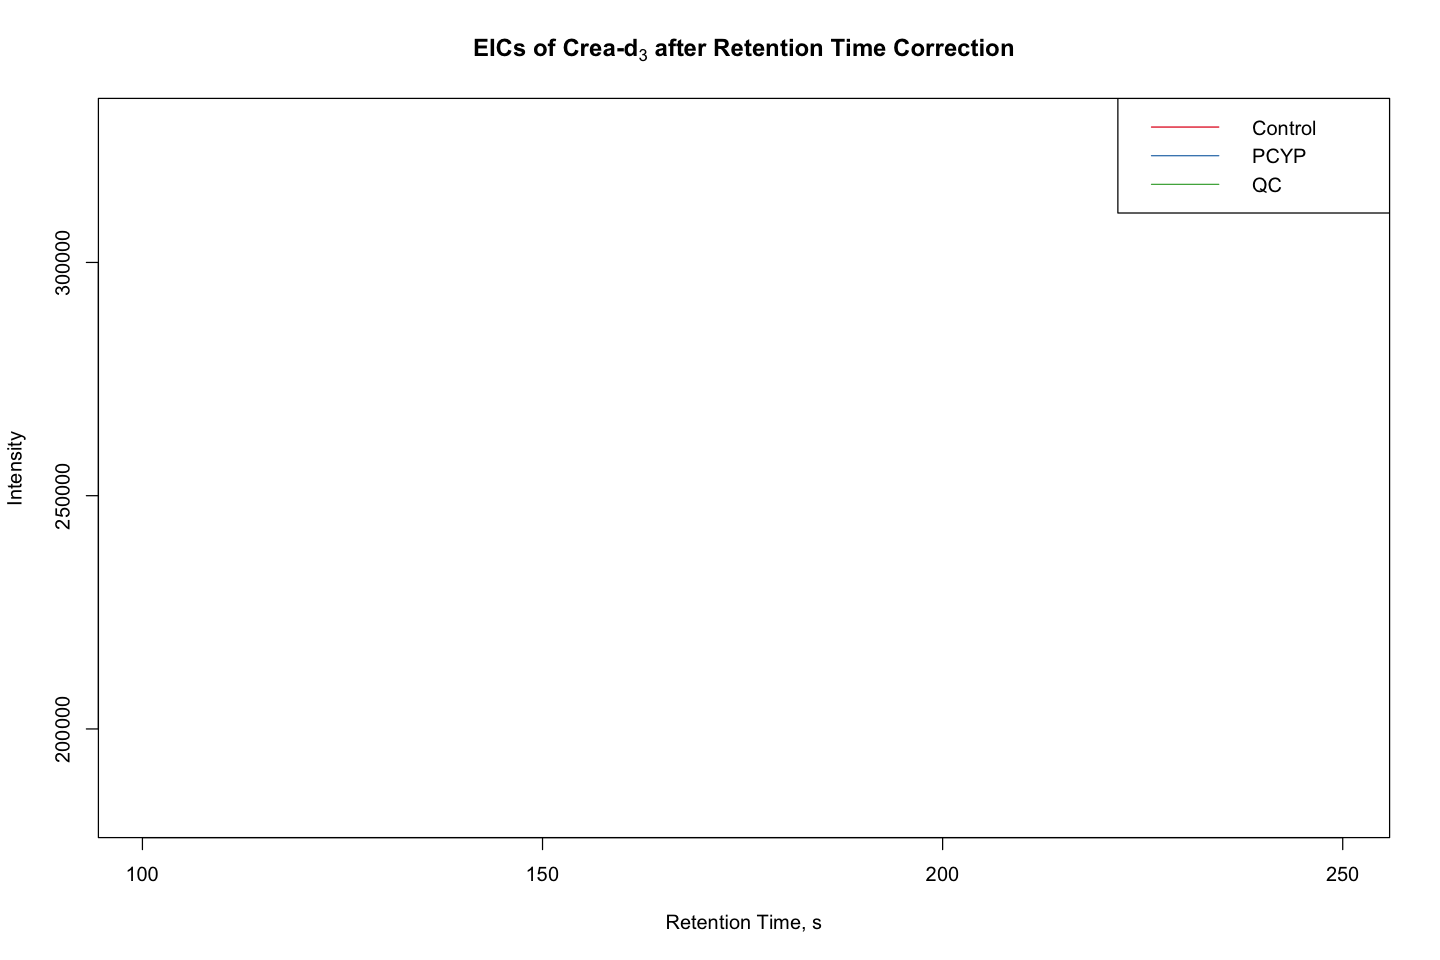

In [19]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
cread3.corr <- chromatogram(set, mz = c(117.0841, 117.0871), rt = c(100, 250))

plot(cread3.corr, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea-d"[3]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [20]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

In [21]:
## Plot trp-d5 after peak grouping
cread3.grouped <- chromatogram(set, mz = c(117.0841, 117.0871), rt = c(150, 200))

## Define the parameters for the peak density method
plotChromPeakDensity(cread3.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea-d"[3]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

ERROR: Error: No chromatographic peaks present. Please run 'findChromPeaks' first.


# Peak Filling

In [22]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [23]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [24]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
        mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
    <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT1   375.887   375.887   375.887   69.0900   66.7544   71.9423         8
FT2   375.887   375.887   375.888   77.1309   75.0544   78.1673         6
FT3   375.887   375.887   375.888   63.6431   62.0856   65.7184         7
FT4   380.840   380.839   380.840  370.2395  367.1220  373.3450        16
FT5   382.837   382.837   382.838  370.7530  365.5660  374.9040        17
FT6   384.835   384.835   384.836  370.2380  369.1950  373.8660        15
      Control      PCYP        QC         peakidx  ms_level
    <numeric> <numeric> <numeric>          <list> <integer>
FT1         3         3         2    34,45,51,...         1
FT2         1         1         4  18, 28,135,...         1
FT3         2         1         4    11,19,29,...         1
FT4         5         5         6    12,23,31,...         1
FT5        

In [25]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
        mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
    <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT1   375.887   375.887   375.887   69.0900   66.7544   71.9423         8
FT2   375.887   375.887   375.888   77.1309   75.0544   78.1673         6
FT3   375.887   375.887   375.888   63.6431   62.0856   65.7184         7
FT4   380.840   380.839   380.840  370.2395  367.1220  373.3450        16
FT5   382.837   382.837   382.838  370.7530  365.5660  374.9040        17
FT6   384.835   384.835   384.836  370.2380  369.1950  373.8660        15
      Control      PCYP        QC         peakidx  ms_level       label
    <numeric> <numeric> <numeric>          <list> <integer> <character>
FT1         3         3         2    34,45,51,...         1     M376T69
FT2         1         1         4  18, 28,135,...         1     M376T77
FT3         2         1         4    11,19,29,...         1     M376T64
FT4        

In [26]:
assay(results) %>% 
head()

,QC_1.mzXML,QC_2.mzXML,QC_3.mzXML,QC_4.mzXML,QC_5.mzXML,1h_Plasma_Rat_PCYP_1.mzXML,1h_Plasma_Rat_PCYP_2.mzXML,1h_Plasma_Rat_Control_2.mzXML,1h_Plasma_Rat_Control_3.mzXML,1h_Plasma_Rat_Control_4.mzXML,QC_6.mzXML,1h_Plasma_Rat_Control_1.mzXML,1h_Plasma_Rat_PCYP_3.mzXML,1h_Plasma_Rat_Control_5.mzXML,1h_Plasma_Rat_PCYP_5.mzXML,1h_Plasma_Rat_PCYP_4.mzXML,QC_7.mzXML
FT1,NA,NA,NA,NA,125958299,54042175,66015829,128842765,46398666,120824348,NA,NA,NA,NA,NA,62834487,63043362
FT2,NA,NA,78724729,75743023,NA,NA,NA,NA,NA,NA,69101516,82974683,NA,NA,NA,34383781,50358325
FT3,NA,61238322,51504325,35358293,NA,31960724,NA,NA,31341107,NA,47739784,58446843,NA,NA,NA,NA,NA
FT4,NA,115147914,121082910,104642567,60700068,116167400,56624444,50587402,110204625,74913199,112923434,105576340,83144681,118739541,111295338,110103712,111598830
FT5,180307447,239030502,208949908,161467299,100257971,299664999,96361378,258858466,222630529,228262033,214691390,134850695,163584992,184014086,252311349,219982870,207045550
FT6,NA,123524731,130619046,88988415,53631156,108265595,NA,123952445,139659589,116957582,128508281,138031613,92858409,98110623,99934902,106463542,112864253


In [28]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 4 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 50  60  80  100  
Found isotopes: 0 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 4 Groups... 
 % finished: 50  60  80  100  

Calculating graph cross linking in 4 Groups... 
 % finished: 50  60  80  100  
New number of ps-groups:  4 
xsAnnotate has now 4 groups, instead of 4 
Generating peak matrix for peak annotation!

Calculating possible adducts in 4 Groups... 
 % finished: 50  60  80  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [29]:
assays(results)

List of length 1
names(1): raw

In [30]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [31]:
assays(results)

List of length 2
names(2): raw scaled

In [32]:
results %>%
assay("scaled") %>%
head()

,QC_1.mzXML,QC_2.mzXML,QC_3.mzXML,QC_4.mzXML,QC_5.mzXML,1h_Plasma_Rat_PCYP_1.mzXML,1h_Plasma_Rat_PCYP_2.mzXML,1h_Plasma_Rat_Control_2.mzXML,1h_Plasma_Rat_Control_3.mzXML,1h_Plasma_Rat_Control_4.mzXML,QC_6.mzXML,1h_Plasma_Rat_Control_1.mzXML,1h_Plasma_Rat_PCYP_3.mzXML,1h_Plasma_Rat_Control_5.mzXML,1h_Plasma_Rat_PCYP_5.mzXML,1h_Plasma_Rat_PCYP_4.mzXML,QC_7.mzXML
FT1,7.496114,7.496114,7.496114,7.496114,8.100227,7.732733,7.819648,8.110060,7.666505,8.082154,7.496114,7.496114,7.496114,7.496114,7.496114,7.798198,7.799639
FT2,7.496114,7.496114,7.896111,7.879343,7.496114,7.496114,7.496114,7.496114,7.496114,7.496114,7.839488,7.918946,7.496114,7.496114,7.496114,7.536354,7.702071
FT3,7.496114,7.787023,7.711844,7.548491,7.496114,7.504617,7.496114,7.496114,7.496114,7.496114,7.678880,7.766761,7.496114,7.496114,7.496114,7.496114,7.496114
FT4,7.496114,8.061256,8.083083,8.019708,7.783189,8.065084,7.753004,7.704042,8.042200,7.874558,8.052784,8.023567,7.919834,8.074595,8.046477,8.041802,8.047660
FT5,8.256014,8.378453,8.320042,8.208085,8.001119,8.476636,7.983903,8.413062,8.347585,8.358434,8.331815,8.129853,8.213743,8.264851,8.401937,8.342389,8.316066
FT6,7.496114,8.091754,8.116007,7.949333,7.729417,8.034490,7.496114,8.093255,8.145071,8.068028,8.108931,8.139979,7.967821,7.991716,7.999717,8.027201,8.052556


# Normalisation

In [35]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [36]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 117.0856, rt = 185, 5, 10)

In [37]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

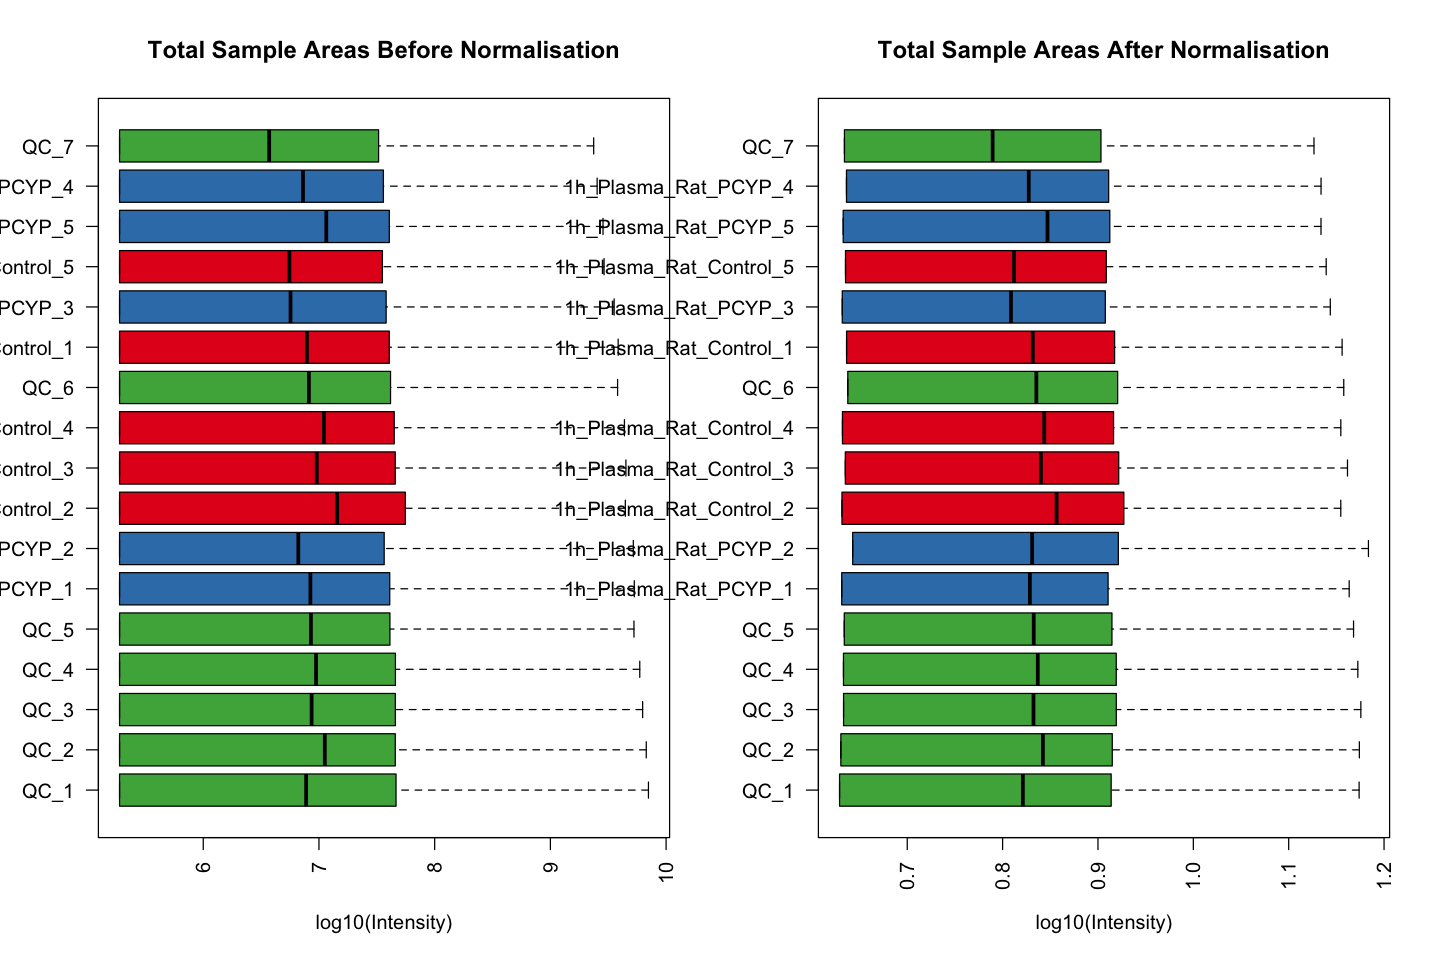

In [38]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [33]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [34]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [35]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

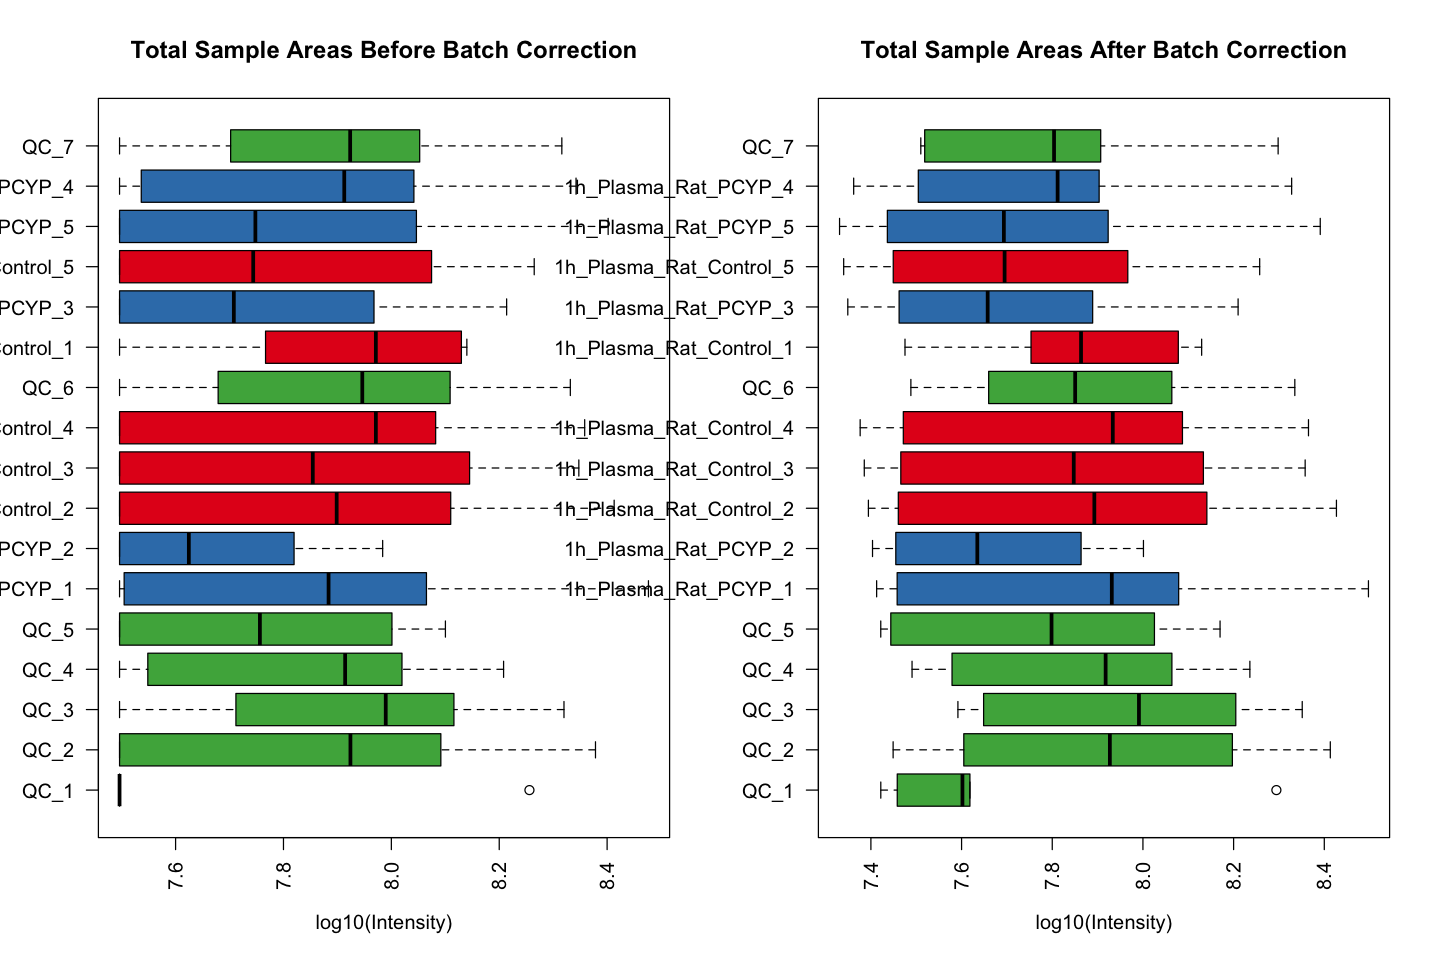

In [36]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [37]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

ERROR: Error in assay(results, "scaled")[51, ]: Indizierung außerhalb der Grenzen


In [38]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'plot': Objekt des Typs 'closure' ist nicht indizierbar
